
# **Calculating WMD and Cosine Score for JSTOR Article Samples**



Computational Literature Review

Creator: Nancy Xu

Date created: September 6, 2022

Date last modified: September 21, 2022

This notebook:
- generates 20 samples of articles in positive/negative classes for each of the 3 perspectives
- calculates Word Mover's Distance (using a gensim Word2Vec model) between an article and core seed terms
- calculates cosine similarity between an article (represented by average of Word2Vec embeddings of its tokens) and average vector of core seed terms (represented by a Word2Vec embedding)
- compares the distribution of WMD scores and cosine similarity scores for each positive/negative perspective

In [1]:
import pandas as pd
import gensim
import pickle
import os
import re
import ast
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from sklearn import utils
cores = multiprocessing.cpu_count()
import gensim
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from numpy import dot, absolute
from numpy.linalg import norm

## Text preprocessing & train phrased Word2Vec model

Load in and preprocess dataframes for each perspective.

In [ ]:
os.chdir('/home/jovyan/work/models_storage/preprocessed_texts')
def open_test_data(path):
    return open(path, 'rb')
with open_test_data('training_relational_preprocessed_100321.pkl') as f:
    rela = pickle.load(f)

with open_test_data('training_demographic_preprocessed_100321.pkl') as f:
    demog = pickle.load(f)

with open_test_data('training_orgs_preprocessed_100321.pkl') as f:
    orgs = pickle.load(f)

with open_test_data('training_cultural_preprocessed_100321.pkl') as f:
    cult = pickle.load(f)
    

import itertools
full_text = []

for i in cult['text']:
    joined = list(itertools.chain(*i))
    full_text.append(" ".join(joined))

full_text_demog = []
for i in demog['text']:
    joined = list(itertools.chain(*i))
    full_text_demog.append(" ".join(joined))

full_text_orgs = []
for j in orgs['text']:
    joined = list(itertools.chain(*j))
    full_text_orgs.append(" ".join(joined))

full_text_rela = []
for j in rela['text']:
    joined = list(itertools.chain(*j))
    full_text_rela.append(" ".join(joined))

cult['full_text'] = full_text
demog['full_text'] = full_text_demog
orgs['full_text'] = full_text_orgs
rela['full_text'] = full_text_rela

def remove_tags(article):
    article = re.sub('<plain_text> <page sequence="1">', '', article)
    article = re.sub(r'</page>(\<.*?\>)', ' \n ', article)
    # xml tags
    article = re.sub(r'<.*?>', '', article)
    article = re.sub(r'<body.*\n\s*.*\s*.*>', '', article)
    return article

tags_removed = [remove_tags(art) for art in cult['full_text']]
tags_removed_demog = [remove_tags(art) for art in demog['full_text']]
tags_removed_org = [remove_tags(art) for art in orgs['full_text']]
tags_removed_rela = [remove_tags(art) for art in rela['full_text']]
cult['text_no_tags'] = tags_removed
demog['text_no_tags'] = tags_removed_demog
orgs['text_no_tags'] = tags_removed_org
rela['text_no_tags'] = tags_removed_rela

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['one', 'two', 'three', 'amp', 'may', 'can', 'new', 'also', 'and'])

import string
import re
import nltk

def word_process(tt):
    """
    helper function to lower text, remove stop words, numbers, and empty 
    """
    
    tt = tt.lower()
    
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~=\n'''
    # Removing punctuations in string 
    # Using loop + punctuation string 


    for ele in tt:  
        if ele in punc:  
            tt = tt.replace(ele, " ")  

    # read tokens
    tokens = tt.split()
    lst = [token.translate(punc).lower() for token in tokens ]
    
    #remove stop words
    filtered = []
    for i in lst:
        if i not in stop_words:
            filtered.append(i)
    
    # removing singular numbers and singular letters
    pattern = '[0-9]'
    filtered = [re.sub(pattern, '', i) for i in filtered] 
    new = []
    for inp in filtered:
        new.append(' '.join( [w for w in inp.split() if len(w)>1] ))
        
    # filter out empty strings 
    new = [i for i in new if i] 

    dt = [d.split() for d in new]
    
  
    st = ''
    for i in dt:
        st = st + " " + i[0]
    return st
    

cult['processed']  =  cult['text_no_tags'].apply(word_process)
rela['processed']  =  rela['text_no_tags'].apply(word_process)
demog['processed']  =  demog['text_no_tags'].apply(word_process)
orgs['processed']  =  orgs['text_no_tags'].apply(word_process)

cult_pos = cult[cult['cultural_score']==1]
cult_neg = cult[cult['cultural_score']==0]

rela_pos = rela[rela['relational_score']==1]
rela_neg = rela[rela['relational_score']==0]

demog_pos = demog[demog['demographic_score']==1]
demog_neg = demog[demog['demographic_score']==0]

pos_cult = cult_pos.sample(20, replace = False)
neg_cult = cult_neg.sample(20, replace = False)

pos_rela = rela_pos.sample(20, replace = False)
neg_rela = rela_neg.sample(20, replace = False)

pos_demog = demog_pos.sample(20, replace = False)
neg_demog = demog_neg.sample(20, replace = False)

pos_cult.to_csv('/home/jovyan/work/nancyxu/pos_cult.csv')
neg_cult.to_csv('/home/jovyan/work/nancyxu/neg_cult.csv')
pos_rela.to_csv('/home/jovyan/work/nancyxu/pos_rela.csv')
neg_rela.to_csv('/home/jovyan/work/nancyxu/neg_rela.csv')
pos_demog.to_csv('/home/jovyan/work/nancyxu/pos_demog.csv')
neg_demog.to_csv('/home/jovyan/work/nancyxu/neg_demog.csv')


In [2]:

pos_cult = pd.read_csv('pos_cult.csv')
neg_cult = pd.read_csv('neg_cult.csv')
pos_rela = pd.read_csv('pos_rela.csv')
neg_rela = pd.read_csv('neg_rela.csv')
pos_demog = pd.read_csv('pos_demog.csv')
neg_demog = pd.read_csv('neg_demog.csv')


load in pretrained phrased w2v model

In [5]:
w2v=Word2Vec.load('word2vec_phrased_filtered_300d_2020_sept5.bin')

In [86]:
# import numpy as np
# def find_mean_and_closest_article(article,df,topk):
#     """
#     calcalate the mean wmd of a certain article from other articles in the same perspective,
#     then give the top k closest articles in the same perspective.
#     """
#     d = []
#     for i in np.arange(len(df)):
#         d.append(calc_wmd(article,df.loc[i,'processed']))
#     dis_dict = pd.DataFrame(list(zip(d,df['processed'])), columns = ['distance', 'article'])
#     dis_dict['full_text'] = df['full_text']
#     dis_dict['edited_filename'] = df['edited_filename'] 
#     dis_dict = dis_dict[dis_dict['article']!=article]
#     srted = dis_dict.sort_values('distance').head(topk)

#     return np.mean(dis_dict['distance']), tuple(zip(srted['edited_filename'], srted['distance']))
        
# def get_cols_sims(df):
#     """
#     get mean wmd similarity scores 
#     """
#     results = pos_cult['processed'].apply(lambda x: find_closest_article(x,pos_cult,10))
#     mean_sims_score = [i[0] for i in results]
#     top10_sims_articles = [i[1] for i in results]
#     df['mean_sims_score'] = mean_sims_score
#     df['top10_sims_articles'] = top10_sims_articles
#     return df.sort_values('mean_sims_score')

## Compute WMD between an article and perspective seed terms

reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_wmd.html

In [6]:
def calc_wmd(a,b):
    return w2v.wmdistance(a,b)

In [7]:
def read_txt_lst(file):
    txt_file = open(file, "r")
    file_content = txt_file.read()
    # print("The file content are: ", file_content)

    content_list = file_content.split("\n")
    txt_file.close()
    return content_list

In [8]:
dem_core=read_txt_lst('demographic_core.txt')
rela_core=read_txt_lst('relational_core.txt')
cult_core = read_txt_lst('cultural_core.txt')

In [9]:
dem_core=[re.sub(r'\s','_',x) for x in dem_core]
rela_core=[re.sub(r'\s','_',x) for x in rela_core]
cult_core=[re.sub(r'\s','_',x) for x in cult_core]

In [85]:

def build_phrases(sentences):
    phrases = Phrases(sentences, min_count = 5, threshold = 7, progress_per = 1000)
    return Phraser(phrases)

In [10]:
def get_sims_with_perspective(article):
  """
  get wmd similarity between this article and the core terms of each perspective
  """

  ## first build bigram from the article

  ss = [article.split()]
  bb = build_phrases(ss)
  pb = [bb[i] for i in ss][0]

  dem_score = calc_wmd(pb,(dem_core))
  rela_score = calc_wmd(pb,(rela_core))
  cult_score = calc_wmd(pb,(cult_core))
  return (dem_score,rela_score,cult_score)

In [13]:
get_sims_with_perspective(pos_cult.loc[0,'processed'])

/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_12900/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)


(4.198177976094678, 4.013062402306361, 3.9515340515701287)

In [ ]:
get_sims_with_perspective(pos_rela.loc[0,'processed'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  


(5.511709636011158, 5.235622040175475, 5.398345213885615)

In [14]:

def get_sim_perspective(df):

    """
    returns modified df with extra columns dem_score,rela_score,cult_score
    denoting the wmd score calculated for each article.
    """
    tqdm.pandas()

    results=df['processed'].apply(lambda x:get_sims_with_perspective(x))
    dem_scores = [i[0] for i in results]
    rela_scores = [i[1] for i in results]
    cult_scores = [i[2] for i in results]
    df['dem_scores'] = dem_scores
    df['rela_scores'] = rela_scores
    df['cult_scores']= cult_scores
    return df

In [15]:
pos_cult = get_sim_perspective(pos_cult)
neg_cult = get_sim_perspective(neg_cult)

pos_demog = get_sim_perspective(pos_demog)
neg_demog = get_sim_perspective(neg_demog)

pos_rela = get_sim_perspective(pos_rela)
neg_rela = get_sim_perspective(neg_rela)

/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_12900/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_12900/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_12900/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_12900/728712704.py:2: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  return w2v.wmdistance(a,b)
/var/folders/l0/d6tznk515rlb1sw7x2cnp5pc0000gn/T/ipykernel_12900/728712704.p

## Calculate cosine similarity score between the article and each perspective

Using Word2Vec to get vector representations of the text in each jstor article, average them to get the article embedding, then calculate cosine similarity between the embedding of each article and average w2v vector for each perspective.

reference: https://github.com/h2researchgroup/embeddings/blob/main/preprocessing/cosine_values_calculate_word2vec.py

In [20]:
cult_core_embs=[]
for x in cult_core:
  try:
    cult_core_embs.append(w2v.wv[x])
  except:
    pass


In [21]:
demog_core_embs=[]
for x in dem_core:
  try:
    demog_core_embs.append(w2v.wv[x])
  except:
    pass


In [22]:
rela_core_embs=[]
for x in rela_core:
  try:
    rela_core_embs.append(w2v.wv[x])
  except:
    pass


In [23]:
import numpy as np
rela_core_embs_mean = np.mean(rela_core_embs, axis=0)
cult_core_embs_mean = np.mean(cult_core_embs, axis=0)
demog_core_embs_mean = np.mean(demog_core_embs, axis=0)

In [41]:
def doc_words_cosine(doc):
    """
  doc = str of text
  get cosine similarity scores between the document embedding and average emb of the core terms in each perspective.
  """
    ss = [doc.split()]
    bb = build_phrases(ss)
    pb = [bb[i] for i in ss][0]
    article_embs=[]
    for k in pb:
      try:
        article_embs.append(w2v.wv[k])
      except:
        pass
    doc_vec = np.mean(np.array(article_embs), axis=0)
    cult_sim = absolute(dot(doc_vec, cult_core_embs_mean)/(norm(doc_vec)*norm(cult_core_embs_mean)))
    rela_sim = absolute(dot(doc_vec, rela_core_embs_mean)/(norm(doc_vec)*norm(rela_core_embs_mean)))
    demog_sim = absolute(dot(doc_vec, demog_core_embs_mean)/(norm(doc_vec)*norm(demog_core_embs_mean)))
    return (demog_sim,rela_sim,cult_sim)

In [42]:
def apply_doc_words_cosine(df):

  """
  applies doc_words_cosine on the processed texts in each df
  returns modified df with new columns dem_sim,rela_sim,cult_sim
  """

  results=df['processed'].apply(lambda x:doc_words_cosine(x))
  dem_scores = [i[0] for i in results]
  rela_scores = [i[1] for i in results]
  cult_scores = [i[2] for i in results]
  df['dem_sim'] = dem_scores
  df['rela_sim'] = rela_scores
  df['cult_sim']= cult_scores

  return df

In [43]:
pos_cult = apply_doc_words_cosine(pos_cult)
neg_cult = apply_doc_words_cosine(neg_cult)

pos_demog = apply_doc_words_cosine(pos_demog)
neg_demog = apply_doc_words_cosine(neg_demog)

pos_rela = apply_doc_words_cosine(pos_rela)
neg_rela = apply_doc_words_cosine(neg_rela)

To classify an article with WMD, get the perspective with the smallest distance.

In [45]:
pos_rela['classified_perspective_wmd']=pos_rela.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
neg_rela['classified_perspective_wmd']=neg_rela.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
pos_cult['classified_perspective_wmd']=pos_cult.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
neg_cult['classified_perspective_wmd']=neg_cult.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
pos_demog['classified_perspective_wmd']=pos_demog.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)
neg_demog['classified_perspective_wmd']=neg_demog.apply(lambda x:np.argmin([x.dem_scores,x.rela_scores,x.cult_scores]),axis=1)

In [46]:
perspective_dict={0:'demographic', 1:'relational', 2:'cultural'}

In [47]:
pos_rela['classified_perspective_wmd'] = pos_rela['classified_perspective_wmd'].replace(perspective_dict)
neg_rela['classified_perspective_wmd'] = neg_rela['classified_perspective_wmd'].replace(perspective_dict)
pos_cult['classified_perspective_wmd'] = pos_cult['classified_perspective_wmd'].replace(perspective_dict)
neg_cult['classified_perspective_wmd'] = neg_cult['classified_perspective_wmd'].replace(perspective_dict)
pos_demog['classified_perspective_wmd'] = pos_demog['classified_perspective_wmd'].replace(perspective_dict)
neg_demog['classified_perspective_wmd'] = neg_demog['classified_perspective_wmd'].replace(perspective_dict)

To classify an article with cosine similarity, get the perspective with the biggest cosine similarity.

In [48]:
pos_rela['classified_perspective_cos']=pos_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_rela['classified_perspective_cos']=neg_rela.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_cult['classified_perspective_cos']=pos_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_cult['classified_perspective_cos']=neg_cult.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
pos_demog['classified_perspective_cos']=pos_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)
neg_demog['classified_perspective_cos']=neg_demog.apply(lambda x:np.argmax([x.dem_sim,x.rela_sim,x.cult_sim]),axis=1)

In [49]:
pos_rela['classified_perspective_cos'] = pos_rela['classified_perspective_cos'].replace(perspective_dict)
neg_rela['classified_perspective_cos'] = neg_rela['classified_perspective_cos'].replace(perspective_dict)
pos_cult['classified_perspective_cos'] = pos_cult['classified_perspective_cos'].replace(perspective_dict)
neg_cult['classified_perspective_cos'] = neg_cult['classified_perspective_cos'].replace(perspective_dict)
pos_demog['classified_perspective_cos'] = pos_demog['classified_perspective_cos'].replace(perspective_dict)
neg_demog['classified_perspective_cos'] = neg_demog['classified_perspective_cos'].replace(perspective_dict)

In [50]:
pos_cult

,Unnamed: 0,Unnamed: 0.1,text,cultural_score,primary_subject,edited_filename,article_name,full_text,text_no_tags,processed,...,rela_wmd,cult_wmd,dem_scores,rela_scores,cult_scores,dem_sim,rela_sim,cult_sim,classified_perspective_wmd,classified_perspective_cos
0,11,689,"[['Organization', 'inf""', 'Vol.', 'No.', 'Janu...",1.0,Management & Organizational Behavior,10.2307_27765958,Young and No Money? Never Mind: The Material I...,"Organization inf"" Vol. No. January-February is...","Organization inf"" Vol. No. January-February is...",organization inf vol january february issn ei...,...,0.682218,0.707098,4.198178,4.013062,3.951534,0.670351,0.730856,0.660321,cultural,relational
1,18,304,"[['Strategic', 'Management', 'Journal,', 'Vol....",0.0,Management & Organizational Behavior,10.2307_2486972,Strategy and Environment as Determinants of Pe...,"Strategic Management Journal, Vol. STRATEGY AN...","Strategic Management Journal, Vol. STRATEGY AN...",strategic management journal vol strategy env...,...,0.630988,0.727100,4.252893,4.048409,4.085452,0.618482,0.703193,0.556503,relational,relational
2,16,361,"[['Industrial', 'Crisis', 'Quarterly', 'Elsevi...",0.0,Management & Organizational Behavior,10.2307_26162655,Corporate adjustments to catastrophe: a study ...,Industrial Crisis Quarterly Elsevier Science P...,Industrial Crisis Quarterly Elsevier Science P...,industrial crisis quarterly elsevier science ...,...,0.641322,0.755781,4.336782,4.097857,4.086080,0.564517,0.662166,0.584495,cultural,relational
3,4,410,"[['Linking', 'Organizational', 'Values', 'to',...",1.0,Management & Organizational Behavior,10.2307_2640266,Linking Organizational Values to Relationships...,Linking Organizational Values to Relationships...,Linking Organizational Values to Relationships...,linking organizational values relationships e...,...,0.621884,0.672908,4.270128,4.064819,3.985121,0.583114,0.675422,0.626303,cultural,relational
4,2,32,"[['Protest', 'Group', 'Success:', 'The', 'Impa...",1.0,Sociology,10.2307_20831203,Protest Group Success: The Impact of Group Cha...,Protest Group Success: The Impact of Group Cha...,Protest Group Success: The Impact of Group Cha...,protest group success impact group characteri...,...,0.640756,0.675410,4.162156,3.928476,3.883836,0.577920,0.667337,0.628871,cultural,relational
5,7,555,"[['mir', 'Special', 'Issue', 'mir', 'Managemen...",0.0,Management & Organizational Behavior,10.2307_40836024,The Wealth Effect of Foreign Investor Presence...,mir Special Issue mir Management International...,mir Special Issue mir Management International...,mir special issue mir management internationa...,...,0.634820,0.767546,4.368868,4.109564,4.190112,0.525938,0.653177,0.477560,relational,relational
6,10,550,"[['Manag', 'Int', 'Rev', 'DOI', './sl', 'RESEA...",0.0,Management & Organizational Behavior,10.2307_40658340,Influence of MNC Network Configuration Pattern...,Manag Int Rev DOI ./sl RESEARCH ARTICLE mir ^H...,Manag Int Rev DOI ./sl RESEARCH ARTICLE mir ^H...,manag int rev doi sl research article mir hu ...,...,0.611053,0.615005,4.253727,3.957665,4.066012,0.598603,0.719955,0.551223,relational,relational
7,1,691,"[['Institutional', 'Sources', 'of', 'Practice'...",1.0,Management & Organizational Behavior,10.2307_2667124,Institutional Sources of Practice Variation: S...,Institutional Sources of Practice Variation: S...,Institutional Sources of Practice Variation: S...,institutional sources practice variation staf...,...,0.643490,0.637734,4.199353,4.051942,3.897382,0.651002,0.688351,0.701156,cultural,cultural
8,0,52,"[['IS', 'BIGGER', 'BETTER?', 'EXPLAINING', 'TH...",0.0,Sociology,10.2307_2096406,Is Bigger Better? Explaining the Relationship ...,IS BIGGER BETTER? EXPLAINING THE RELATIONSHIP ...,IS BIGGER BETTER? EXPLAINING THE RELATIONSHIP ...,bigger better explaining relationship organiz...,...,0.678246,0.666087,4.217636,4.030401,4.015203,0.567558,0.643436,0.533882,cultural,relational
9,9,312,"[['MANAGERIAL', 'AND', 'DECISION', 'ECONOMICS,...",0.0,

In [51]:
pos_rela

,Unnamed: 0,Unnamed: 0.1,text,relational_score,primary_subject,edited_filename,article_name,full_text,text_no_tags,processed,...,rela_wmd,cult_wmd,dem_scores,rela_scores,cult_scores,dem_sim,rela_sim,cult_sim,classified_perspective_wmd,classified_perspective_cos
0,0,237,"[['Original', 'Article', 'Sustainable', 'touri...",0.0,Management & Organizational Behavior,10.2307_23745474,Sustainable tourism pedagogy and academic-comm...,Original Article Sustainable tourism pedagogy ...,Original Article Sustainable tourism pedagogy ...,original article sustainable tourism pedagogy...,...,0.650351,0.700012,4.334056,4.198038,4.054259,0.571287,0.584389,0.604313,cultural,cultural
1,1,414,"[['Status,', 'Quality,', 'and', 'Social', 'Ord...",1.0,Management & Organizational Behavior,10.2307_2666962,"Status, Quality, and Social Order in the Calif...","Status, Quality, and Social Order in the Calif...","Status, Quality, and Social Order in the Calif...",status quality social order california wine i...,...,0.729026,0.765182,4.232613,4.082711,4.051049,0.618743,0.650771,0.594306,cultural,relational
2,2,930,"[['Work', 'and', 'Friendship', 'Ties', 'in', '...",1.0,Management & Organizational Behavior,10.2307_2392493,Work and Friendship Ties in Organizations: A C...,Work and Friendship Ties in Organizations: Com...,Work and Friendship Ties in Organizations: Com...,work friendship ties organizations comparativ...,...,0.613767,0.679662,4.163912,3.873773,3.898621,0.597914,0.707941,0.630995,relational,relational
3,3,204,"[['Strategie', 'Management', 'Journal', 'Strat...",1.0,Management & Organizational Behavior,10.2307_20142016,Do Bridging Ties Complement Strong Ties? An Em...,Strategie Management Journal Strat. Mgmt. Publ...,Strategie Management Journal Strat. Mgmt. Publ...,strategie management journal strat mgmt publi...,...,0.586576,0.748402,4.404444,4.166500,4.182005,0.629532,0.731645,0.617341,relational,relational
4,5,789,"[['Network', 'Structure', 'and', 'Knowledge', ...",1.0,Management & Organizational Behavior,10.2307_3556658,Network Structure and Knowledge Transfer: The ...,Network Structure and Knowledge Transfer: The ...,Network Structure and Knowledge Transfer: The ...,network structure knowledge transfer effects ...,...,0.520568,0.789987,4.167715,3.855882,3.896861,0.595412,0.719205,0.615274,relational,relational
5,4,569,"[['Selection-based', 'Learning:', 'The', 'Coev...",0.0,Management & Organizational Behavior,10.2307_4131455,Selection-Based Learning: The Coevolution of I...,Selection-based Learning: The Coevolution of I...,Selection-based Learning: The Coevolution of I...,selection based learning coevolution internal...,...,0.596870,0.688729,4.073430,3.992141,3.953597,0.695344,0.696927,0.627711,cultural,relational
6,6,540,"[['JOURNAL', 'OF', 'MANAGERIAL', 'ISSUES', 'Vo...",0.0,Management & Organizational Behavior,10.2307_40604353,"Responsibilities In The ""New Employment Relati...",JOURNAL OF MANAGERIAL ISSUES Vol. XIII Number ...,JOURNAL OF MANAGERIAL ISSUES Vol. XIII Number ...,journal managerial issues vol xiii number fal...,...,0.626785,0.761633,4.245424,4.075613,3.985669,0.536156,0.605727,0.562672,cultural,relational
7,7,501,"[['CONSTRUCT', 'OF', 'ORGANIZATIONAL', 'SOCIAL...",0.5,Management & Organizational Behavior,10.2307_40226169,A Construct of Organizational Social Effective...,CONSTRUCT OF ORGANIZATIONAL SOCIAL EFFECTIVENE...,CONSTRUCT OF ORGANIZATIONAL SOCIAL EFFECTIVENE...,construct organizational social effectiveness...,...,0.670812,0.611575,4.137115,3.951055,3.857032,0.625566,0.691113,0.651917,cultural,relational
8,8,464,"[['JOURNAL', 'OF', 'ORGANIZATIONAL', 'BEHAVIOR...",0.0,Management & Organizational Behavior,10.2307_3100215,Perceptions of Observed and Model Values of Ma...,"JOURNAL OF ORGANIZATIONAL BEHAVIOR, VOL. Perce...","JOURNAL OF ORGANIZATIONAL BEHAVIOR, VOL. Perce...",journal organizational behavior vol perceptio...,...,0.732856,0.835687,4.313473,4.139499,4.065481,0.504225,0.579892,0.543925,cultural,relational
9,10,397,

In [73]:
pos_demog

,Unnamed: 0,Unnamed: 0.1,text,demographic_score,primary_subject,edited_filename,article_name,full_text,text_no_tags,processed,...,rela_wmd,cult_wmd,dem_scores,rela_scores,cult_scores,dem_sim,rela_sim,cult_sim,classified_perspective_wmd,classified_perspective_cos
0,0,595,"[['Ljiljana', 'Erakovic,', 'Sanjay', 'Goel*', ...",0.0,Management & Organizational Behavior,10.2307_41783571,Board-Management Relationships: Resources and ...,"Ljiljana Erakovic, Sanjay Goel* Board-Manageme...","Ljiljana Erakovic, Sanjay Goel* Board-Manageme...",ljiljana erakovic sanjay goel board managemen...,...,0.589235,0.764416,4.239033,3.893710,3.964574,0.586484,0.752199,0.616873,relational,relational
1,1,355,"[['FROM', 'ENVIRONMENTAL', 'SOCIOLOGIES', 'TO'...",0.0,Management & Organizational Behavior,10.2307_26162369,FROM ENVIRONMENTAL SOCIOLOGIES TO ENVIRONMENTA...,FROM ENVIRONMENTAL SOCIOLOGIES TO ENVIRONMENTA...,FROM ENVIRONMENTAL SOCIOLOGIES TO ENVIRONMENTA...,environmental sociologies environmental socio...,...,0.604546,0.611526,4.301510,4.215382,4.080739,0.607996,0.591720,0.641194,cultural,cultural
2,2,479,"[['Hummelian', 'View', 'of', 'the', 'Gore', 'R...",0.0,Management & Organizational Behavior,10.2307_3380695,A Hummelian View of the Gore Report: Toward a ...,Hummelian View of the Gore Report: Toward Post...,Hummelian View of the Gore Report: Toward Post...,hummelian view gore report toward post progre...,...,0.592690,0.746572,4.235809,4.022983,3.895578,0.572861,0.644635,0.677238,cultural,cultural
3,3,902,"[['Some', 'Effects', 'of', 'Proportions', 'on'...",1.0,Sociology,10.2307_2777808,Some Effects of Proportions on Group Life: Ske...,Some Effects of Proportions on Group Life: Ske...,Some Effects of Proportions on Group Life: Ske...,effects proportions group life skewed sex rat...,...,0.579469,0.766976,4.237793,4.031018,3.901753,0.530569,0.609524,0.633177,cultural,cultural
4,5,896,"[['HIERARCHIES,', 'JOBS,', 'BODIES:', 'Theory'...",1.0,NaN,10.2307_189609,"Hierarchies, Jobs, Bodies: A Theory of Gendere...","HIERARCHIES, JOBS, BODIES: Theory of Gendered ...","HIERARCHIES, JOBS, BODIES: Theory of Gendered ...",hierarchies jobs bodies theory gendered organ...,...,0.657296,0.711999,4.268500,4.060411,3.911604,0.558576,0.615606,0.678937,cultural,cultural
5,4,17,"[['Government', 'Regulatory', 'Powers', 'and',...",0.0,Sociology,10.2307_1385815,Government Regulatory Powers and Church Autono...,Government Regulatory Powers and Church Autono...,Government Regulatory Powers and Church Autono...,government regulatory powers church autonomy ...,...,0.649165,0.666026,4.287796,4.082125,3.931265,0.556133,0.625826,0.682766,cultural,cultural
6,6,203,"[['MANAGEMENT', 'SCIENCE', 'UGH', 'Vol.', 'No....",0.0,Management & Organizational Behavior,10.2307_20122362,On the Recoverability of Choice Behaviors with...,MANAGEMENT SCIENCE UGH Vol. No. January DOI ./...,MANAGEMENT SCIENCE UGH Vol. No. January DOI ./...,management science ugh vol january doi mnsc i...,...,0.663996,0.828509,4.468519,4.335936,4.330244,0.557559,0.561672,0.470944,cultural,relational
7,7,554,"[['mir', 'vol.', 'mir', 'InternotiofMH', 'Rovt...",0.0,Management & Organizational Behavior,10.2307_40835943,Prioritizing Performance Measures Within the B...,mir vol. mir InternotiofMH Rovtew Gabler Verla...,mir vol. mir InternotiofMH Rovtew Gabler Verla...,mir vol mir internotiofmh rovtew gabler verla...,...,0.653215,0.729249,4.245435,4.043953,3.999412,0.545694,0.638492,0.557336,cultural,relational
8,8,611,"[['Organizational', 'Misfits', 'and', 'the', '...",0.0,Management & Organizational Behavior,10.2307_43548332,Organizational Misfits and the Origins of Brok...,Organizational Misfits and the Origins of Brok...,Organizational Misfits and the Origins of Brok...,organizational misfits origins brokerage intr...,...,0.638039,0.724151,4.279688,4.047520,4.066907,0.613154,0.711135,0.596235,relational,relational
9,10,614,"[['Article', 'Does', 'disclosure', 'matter?', ...",0.0,Management & Organizational Behavior,10.2307

In [77]:
drop_columns= ['Unnamed: 0','Unnamed: 0.1','text','mean_wmd_score', 'top10_sims_articles','text_no_tags','processed']

In [82]:
pos_cult = pos_cult.drop(drop_columns,axis = 1 )
neg_cult = neg_cult.drop(drop_columns,axis = 1 )
pos_demog = pos_demog.drop(drop_columns,axis = 1 )
neg_demog = neg_demog.drop(drop_columns,axis = 1 )
pos_rela = pos_rela.drop(drop_columns,axis = 1 )
neg_rela = neg_rela.drop(drop_columns,axis = 1 )


In [84]:
pos_cult.to_csv('pos_cult_sample_wmd_cos.csv')
neg_cult.to_csv('neg_cult_sample_wmd_cos.csv')
pos_demog.to_csv('pos_demog_sample_wmd_cos.csv')
neg_demog.to_csv('neg_demog_sample_wmd_cos.csv')
pos_rela.to_csv('pos_rela_sample_wmd_cos.csv')
neg_rela.to_csv('neg_rela_sample_wmd_cos.csv')

## Inspecting Distribution of Similarity Metrics

In [53]:
import matplotlib.pyplot as plt

In [54]:
from sklearn.preprocessing import normalize

#### Overlayed Distributions

- normalize cosine similarity (range 0-1) and wmd (range 4-6) since they are on different scales
- invert the normalized wmd score, since originally the bigger the wmd, the more distant 2 vectors are

**Relational samples**

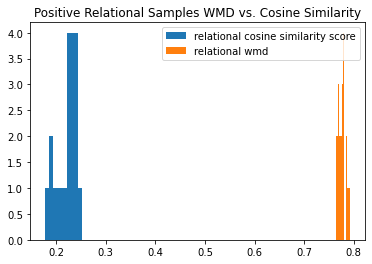

In [55]:

plt.hist(normalize([pos_rela['rela_sim']])[0], label = 'relational cosine similarity score')
plt.hist(1-normalize([pos_rela['rela_scores']])[0], label = 'relational wmd')
plt.legend(loc='upper right')
plt.title('Positive Relational Samples WMD vs. Cosine Similarity')
plt.show()

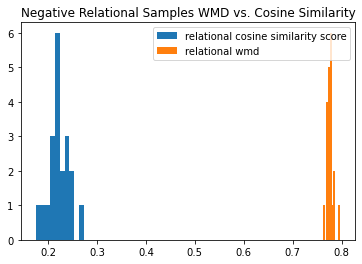

In [56]:
plt.hist(normalize([neg_rela['rela_sim']])[0], label = 'relational cosine similarity score')
plt.hist(1-normalize([neg_rela['rela_scores']])[0], label = 'relational wmd')
plt.legend(loc='upper right')
plt.title('Negative Relational Samples WMD vs. Cosine Similarity')
plt.show()

**Demographic samples**

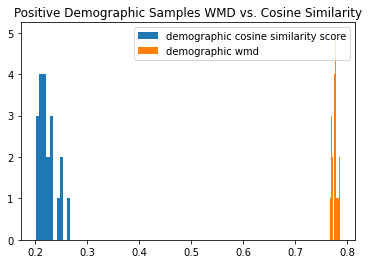

In [57]:
plt.hist(normalize([pos_demog['dem_sim']])[0], label = 'demographic cosine similarity score')
plt.hist(1-normalize([pos_demog['dem_scores']])[0], label = 'demographic wmd')
plt.legend(loc='upper right')
plt.title('Positive Demographic Samples WMD vs. Cosine Similarity')
plt.show()

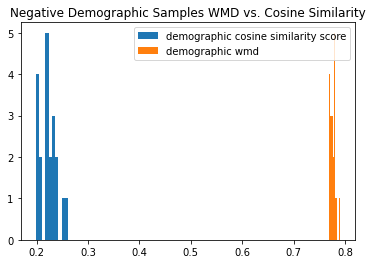

In [58]:
plt.hist(normalize([neg_demog['dem_sim']])[0], label = 'demographic cosine similarity score')
plt.hist(1-normalize([neg_demog['dem_scores']])[0], label = 'demographic wmd')
plt.legend(loc='upper right')
plt.title('Negative Demographic Samples WMD vs. Cosine Similarity')
plt.show()

**Cultural samples**

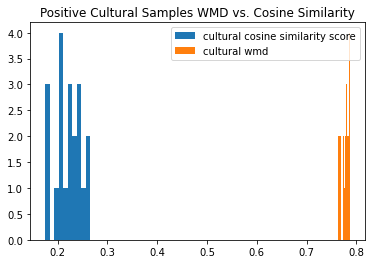

In [59]:
plt.hist(normalize([pos_cult['cult_sim']])[0], label = 'cultural cosine similarity score')
plt.hist(1-normalize([pos_cult['cult_scores']])[0], label = 'cultural wmd')
plt.legend(loc='upper right')
plt.title('Positive Cultural Samples WMD vs. Cosine Similarity')
plt.show()

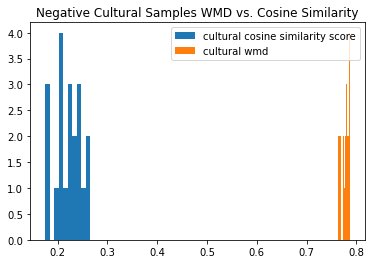

In [60]:
plt.hist(normalize([neg_cult['cult_sim']])[0], label = 'cultural cosine similarity score')
plt.hist(1-normalize([neg_cult['cult_scores']])[0], label = 'cultural wmd')
plt.legend(loc='upper right')
plt.title('Negative Cultural Samples WMD vs. Cosine Similarity')
plt.show()

Separate Distributions

**Relational samples**

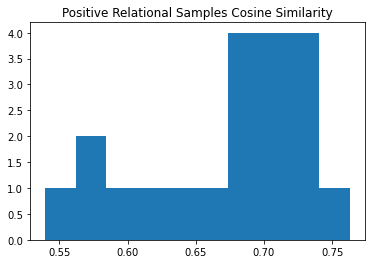

In [61]:
plt.hist(([pos_rela['rela_sim']]), label = 'relational cosine similarity score')
plt.title('Positive Relational Samples Cosine Similarity')
plt.show()

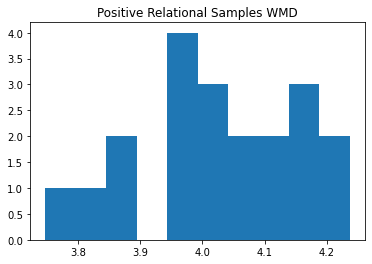

In [62]:
plt.hist(([pos_rela['rela_scores']]), label = 'relational wmd')
plt.title('Positive Relational Samples WMD')
plt.show()

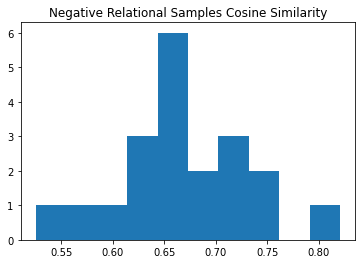

In [63]:
plt.hist(([neg_rela['rela_sim']]), label = 'relational cosine similarity score')
plt.title('Negative Relational Samples Cosine Similarity')
plt.show()

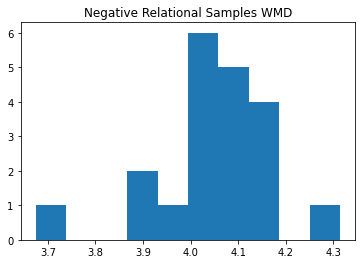

In [64]:
plt.hist(([neg_rela['rela_scores']]), label = 'relational cosine similarity score')
plt.title('Negative Relational Samples WMD')
plt.show()

**Demographic Samples**

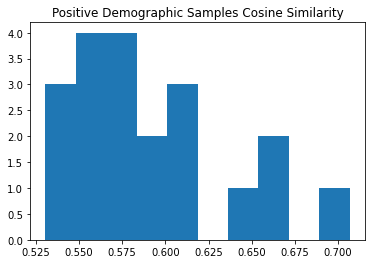

In [65]:
plt.hist(([pos_demog['dem_sim']]))
plt.title('Positive Demographic Samples Cosine Similarity')
plt.show()

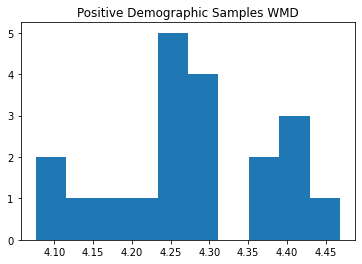

In [66]:
plt.hist(([pos_demog['dem_scores']]))
plt.title('Positive Demographic Samples WMD')
plt.show()

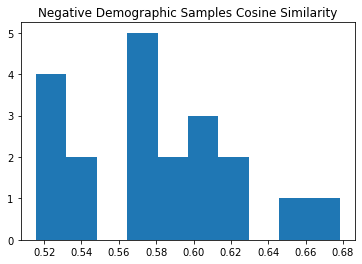

In [67]:
plt.hist(([neg_demog['dem_sim']]))
plt.title('Negative Demographic Samples Cosine Similarity')
plt.show()

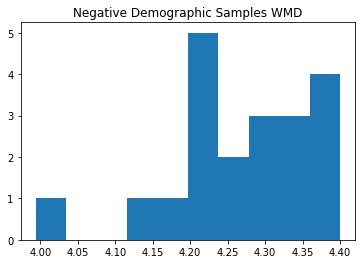

In [68]:
plt.hist(([neg_demog['dem_scores']]))
plt.title('Negative Demographic Samples WMD')
plt.show()

**Cultural Samples**

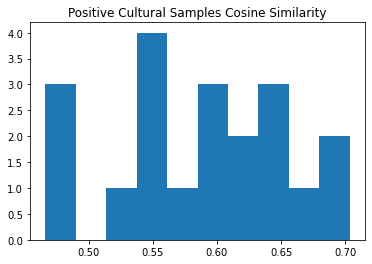

In [69]:
plt.hist(([pos_cult['cult_sim']]))
plt.title('Positive Cultural Samples Cosine Similarity')
plt.show()

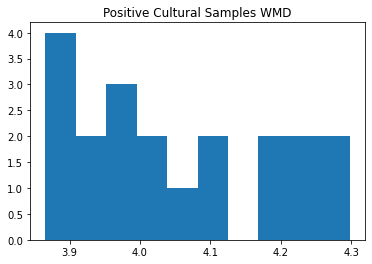

In [70]:
plt.hist(([pos_cult['cult_scores']]))
plt.title('Positive Cultural Samples WMD')
plt.show()

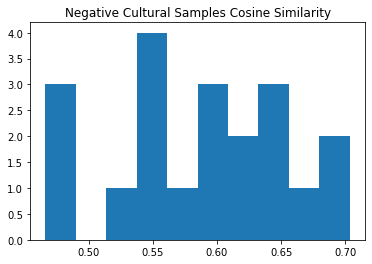

In [71]:
plt.hist(([neg_cult['cult_sim']]))
plt.title('Negative Cultural Samples Cosine Similarity')
plt.show()

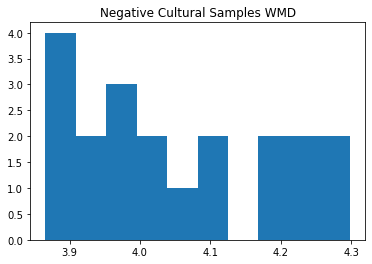

In [72]:
plt.hist(([neg_cult['cult_scores']]))
plt.title('Negative Cultural Samples WMD')
plt.show()